In [110]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import torch
import matplotlib.pyplot as plt
import torchvision

import seaborn as sns
from tqdm.notebook import tqdm

from torchvision.ops import batched_nms
import mmcv

from ensemble_boxes import *

from matplotlib.pyplot import imshow
from PIL import Image

In [104]:
def plot_image(img_path, boxes, labels, scores,  score_thr=0.0):
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    image = image.astype('float32')
    
    categories = [
        { 'id':0, 'name': 'Aortic enlargement'},
        { 'id':1, 'name': 'Atelectasis'},
        { 'id':2, 'name': 'Calcification'},
        { 'id':3, 'name': 'Cardiomegaly'},
        { 'id':4, 'name': 'Consolidation'},
        { 'id':5, 'name': 'ILD'},
        { 'id':6, 'name': 'Infiltration'},
        { 'id':7, 'name': 'Lung Opacity'},
        { 'id':8, 'name': 'Nodule/Mass'},
        { 'id':9, 'name': 'Other lesion'},
        { 'id':10, 'name': 'Pleural effusion'},
        { 'id':11, 'name': 'Pleural thickening'},
        { 'id':12, 'name': 'Pneumothorax'},
        { 'id':13, 'name': 'Pulmonary fibrosis'},
        { 'id':14, 'name': 'No finding'},
    ] 
    
    plt.figure(figsize=(16,16))
    
    for box, label, score in zip(boxes, labels, scores):
        
        if score < score_thr:
            continue
        
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (225,0,0), 4)
        label = categories[label]['name'].upper() + " " + str(score)
        print(label, box)
        cv2.putText(image, 
                    label,
                    (box[0], box[1]), 
                    fontFace = cv2.FONT_HERSHEY_COMPLEX, 
                    fontScale = 1,
                    color = (255, 0, 0),
                    thickness = 2,
                    lineType = cv2.LINE_AA
                   )
    plt.imshow(image)

In [139]:
import pickle
from ensemble_boxes import *

with open('./test_fold_3.pkl', 'rb') as f:
    data = pickle.load(f)
    
test_df = pd.read_csv('test.csv')

test_healthy = pd.read_csv('test_healthy_kaggle.csv')
test_healthy = test_healthy.set_index('image_id')

submission_vals = []

min_score_thr = 0.0001

iou_thr = 0.45

low_thr = 0.1
high_thr = 0.5

freq_df = []

box_counts = []

for _id, preds in tqdm(zip(range(len(test_df)), data)):
    
    r = test_df.iloc[_id]
    
    image_id = r['image_id']
    
    health_score = test_healthy.loc[image_id]['target']
    
    width = r['width']
    height = r['height']

    
    boxes = []
    scores = []
    labels = []
    
    for i, pred in enumerate(preds):
        if len(pred):
            for p in pred:
                
                score = p[4].astype(float)
                
                box = p[:4]

                box[0] = box[0] / (width)
                box[2] = box[2] / (width)
                box[1] = box[1] / (height)
                box[3] = box[3] / (height)

                boxes.append(box)
                scores.append(score)
                labels.append(i)

                freq_df.append(dict(
                    class_id=i,
                    image_id=image_id
                ))
                    
    if len(boxes) == 0 or health_score < low_thr:
        pred_str = '14 1 0 0 1 1'
        submission_vals.append([image_id, pred_str])
        freq_df.append(dict(
                    class_id=14,
                    image_id=image_id
                ))
        continue 
    
#     boxes = np.clip(boxes, 0.0, 1.0)
    boxes, scores, labels = nms([boxes], [scores], [labels], iou_thr=iou_thr)
    
    boxes[:, 0] = boxes[:, 0]*width
    boxes[:, 2] = boxes[:, 2]*width
    boxes[:, 1] = boxes[:, 1]*height
    boxes[:, 3] = boxes[:, 3]*height
    
    scaled_boxes = boxes.astype(int)
    labels = labels.astype(int)

    _id_preds = []
    
    box_counts.append(len(boxes))
    
    for i in range(len(boxes)):
        _id_preds.append(str(labels[i]))
        _id_preds.append(str(scores[i].round(2)))
        _id_preds.append(str(boxes[i][0]))
        _id_preds.append(str(boxes[i][1]))
        _id_preds.append(str(boxes[i][2]))
        _id_preds.append(str(boxes[i][3]))

    pred_str = " ".join(_id_preds)
        
    if high_thr > health_score > low_thr:
        pred_str += f' 14 {round(health_score, 3)} 0 0 1 1'
    submission_vals.append([image_id, pred_str])
    
print(np.mean(box_counts))
df = pd.DataFrame(submission_vals, columns = ['image_id','PredictionString'])

0it [00:00, ?it/s]

54.73196881091618


In [140]:
len(df[df['PredictionString'] == '14 1 0 0 1 1'])

1974

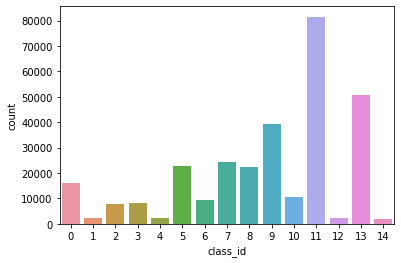

In [141]:
freq_df = pd.DataFrame(freq_df)

ax = sns.countplot(x="class_id",data=freq_df)

In [134]:
df.to_csv("submission.csv",index=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


990b0dcd83353894c4a2e73738cd6c25
AORTIC ENLARGEMENT 0.31 [1152  379 1780  962]
AORTIC ENLARGEMENT 0.28 [1449  474 1770  827]
AORTIC ENLARGEMENT 0.15 [1459  325 1799 1002]
AORTIC ENLARGEMENT 0.11 [1046  981 2143 1730]
AORTIC ENLARGEMENT 0.1 [1393  386 1836 1577]
CARDIOMEGALY 0.89 [1061 1248 2135 1678]
ILD 0.35 [ 309  312 1225 1577]
ILD 0.24 [1607  341 2303 1707]
ILD 0.13 [ 330  841  940 1523]
ILD 0.12 [1680  889 2222 1692]
ILD 0.1 [ 722  366 1450 1828]
LUNG OPACITY 0.25 [1057  237 1292  652]
LUNG OPACITY 0.16 [1459  325 1799 1002]
LUNG OPACITY 0.15 [ 804  228 1287  607]
LUNG OPACITY 0.11 [1451  465 1769  821]
LUNG OPACITY 0.11 [1504  243 1829  644]
LUNG OPACITY 0.1 [1079  266 1766  892]
NODULE/MASS 0.1 [1464  370 1821 1092]
NODULE/MASS 0.1 [1846  900 1902  956]
NODULE/MASS 0.1 [ 892 1126 1029 1254]
OTHER LESION 0.17 [ 207 1380 1123 1867]
OTHER LESION 0.13 [1464  370 1821 1092]
OTHER LESION 0.12 [1143  343 1777  896]
OTHER LESION 0.11 [ 468  288 1366 1683]
OTHER LESION 0.11 [1460  454 18

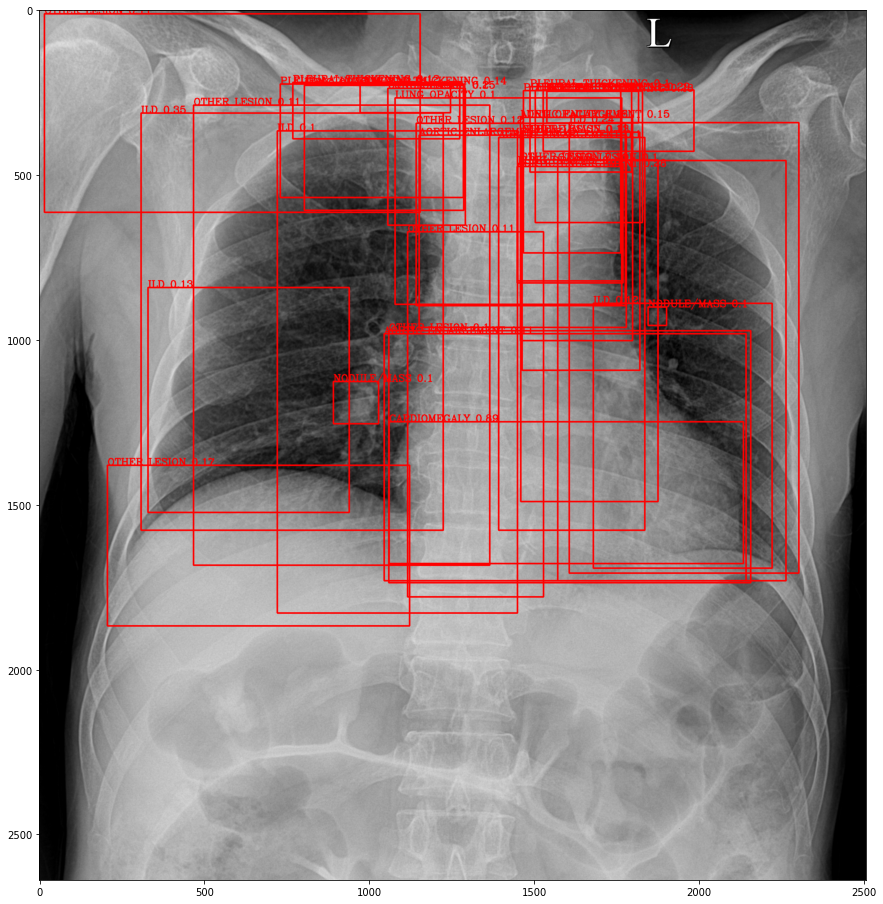

In [142]:
sub = pd.read_csv('submission.csv')

row = sub.iloc[341 - 1]
pred_string = row['PredictionString']
image_id = row['image_id']
print(image_id)
img_path = 'vinbigdata/images/test/' + image_id + '.jpg'

pred = np.array(list(map(lambda x: float(x), pred_string.split(' '))))
pred = pred.reshape(-1,6)

boxes = pred[:, 2:].astype(int) 
scores = pred[:,1].astype(float)
labels = pred[:,0].astype(int)

plot_image(img_path, boxes, labels, scores, score_thr=0.1)